In [1]:
#importing libraries
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from keras.layers import Dense, Input, regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import lightgbm as lgb
import seaborn as sns
from subprocess import call
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
#uploading file (dataset in zip format) to the colab
uploaded1 = files.upload()

Saving train.zip to train.zip


In [4]:
#unzipping the data files
!unzip train.zip

Archive:  train.zip
  inflating: train.psv               


In [5]:
#uploading file (validation in zip format) to the colab
uploaded1 = files.upload()

Saving validation.zip to validation.zip


In [6]:
#unzipping the data files
!unzip validation.zip

Archive:  validation.zip
  inflating: validation.psv          


In [7]:
#uploading file (test data in zip format) to the colab
uploaded1 = files.upload()

Saving test.zip to test.zip


In [8]:
#unzipping the data files
!unzip test.zip

Archive:  test.zip
  inflating: test.psv                


In [0]:
train = pd.read_csv('/content/train.psv', sep = "|")

In [0]:
val = pd.read_csv('/content/validation.psv', sep = "|")

In [0]:
test = pd.read_csv('/content/test.psv', sep = "|")

Feature Engineering

Heart Rate

In [0]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'new_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'new_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'new_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'new_hr'] = 'abnormal'
    train['new_hr'].fillna('Missing', inplace=True)
    return train

In [0]:
#temperature
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'new_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'new_temp'] = 'abnormal'

    train['new_temp'].fillna('Missing', inplace=True)
    return train

In [0]:
#Age
def featuer_engineer_age(train):
    train.loc[train['Age'] >=65, 'new_age'] = 'old'
    train.loc[train['Age'] <1, 'new_age'] = 'infant'
    train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'new_age'] = 'child/adult'
    return train

In [0]:
#O2Stat
def feature_engineer_o2stat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'new_o2stat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'new_o2stat'] = 'abnormal'

    train['new_o2stat'].fillna('Missing', inplace=True)
    return train

In [0]:
#SBP and DBP
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'new_bp'] = 'low'

    train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'new_bp'] = 'normal'


    train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'new_bp'] = 'elevated'


    train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'new_bp'] = 'high'

    train['new_bp'].fillna('Missing', inplace=True)
    return train

In [0]:

#Respiration Rate
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'new_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'new_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'new_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'new_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'new_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'new_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'new_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'new_resp'] = 'abnormal'

    train['new_resp'].fillna('Missing', inplace=True)


    return train

In [0]:
#Transform Train and Validation sets
train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)

In [0]:
val = featuer_engineer_age(val)
val = feature_engineer_blood_pressure(val)
val = feature_engineer_hr(val)
val = feature_engineer_o2stat(val)
val = feature_engineer_temp(val)
val = feature_engineer_resp_rate(val)

In [0]:
#Feature Selection
filtered_columns = ['Gender', 'new_hr', 'new_temp','new_age', 
                    'new_o2stat', 'new_bp','new_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [0]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

In [0]:
#Defining the Pipeline
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))

In [0]:
#Custom Score function
def score_model(model, metric_list, y_true, y_pred):
    metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix, 
                 'avg_precision': average_precision_score}
    df = pd.DataFrame()
    df['model'] = [model]
    for metric in metric_list:
        df[metric] = [metric_dict[metric](y_true, y_pred)]
    return df

Training Model:

I have used two models Logistic Regression and Random Forest Classifier

In [0]:
#Logistic Model
log_pipe_scale = make_pipeline(preprocess_trans_scale, 
                               LogisticRegression(C=0.01, solver = 'lbfgs',
                                                  dual=False) )

log_model = log_pipe_scale.fit(X_train, y_train)

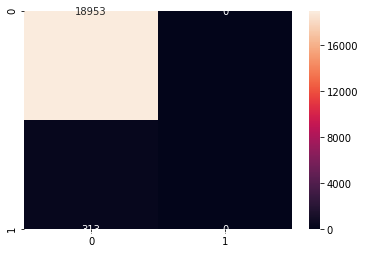

In [28]:
#Prediction and Scoring
pred = log_pipe_scale.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [30]:
score_model('Logistic_regression', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Logistic_regression,0.0,0.0,0.016246


In [0]:
#Defining Custom Threshold
df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

df['actual'] = y_val
df.loc[(df[1] >=0.4), 'pred'] = 1 
df.loc[(df[1] <0.4), 'pred'] = 0

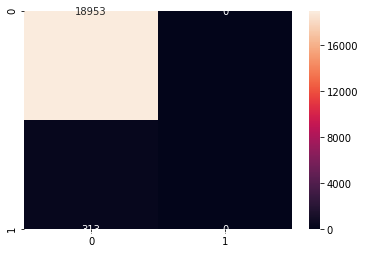

In [38]:
conf_matrix = confusion_matrix(df['actual'], df['pred'])

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [39]:
score_model('Logistic_regression', ['recall','precision','avg_precision'], 
            df['actual'], df['pred'])

,model,recall,precision,avg_precision
0,Logistic_regression,0.0,0.0,0.016246


In [0]:
eval_df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

eval_df['actual'] = y_val

def eval_threshold(eval_df, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        eval_df.loc[(eval_df[1] >=threshold), 'pred'] = 1 
        eval_df.loc[(eval_df[1] <threshold), 'pred'] = 0 
        avg_pre_list.append(average_precision_score(eval_df['actual'], 
                                                    eval_df['pred']))
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(eval_df, list(np.arange(0,1,0.05)))

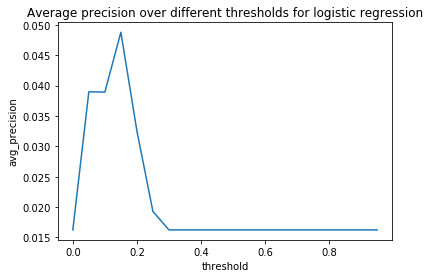

In [41]:
ax=sns.lineplot(comp['threshold'], comp['avg_precision'])
_=ax.set_title('Average precision over different thresholds for logistic regression')

**Random Forest**

Train the Model

In [0]:
rf_pipe_scale = make_pipeline(preprocess_trans_scale, RandomForestClassifier(max_features='sqrt', n_estimators=150))

rf_model = rf_pipe_scale.fit(X_train, y_train)

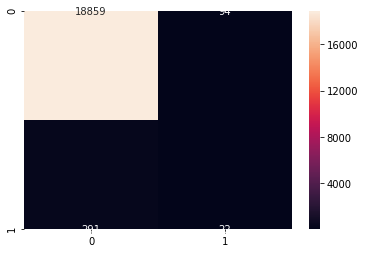

In [32]:
pred = rf_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [33]:
score_model('Random Forest', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Random Forest,0.070288,0.189655,0.028435
